# Проект 3. О вкусной и здоровой пище

# Кузнецовой Анны**

# import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
df.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

## Обработка признаков 

Restaurant_id

In [14]:
# приведем Restaurant_id только к числовому значению
df['Restaurant_id'] = df['Restaurant_id'].apply(lambda x: (x[3:]))

Cuisine Style

In [15]:
# Посмотрим, какие значения хранятся в данном признаке
df['Cuisine Style']

0                                           ['Bar', 'Pub']
1        ['European', 'Scandinavian', 'Gluten Free Opti...
2                                  ['Vegetarian Friendly']
3        ['Italian', 'Mediterranean', 'European', 'Vege...
4        ['Italian', 'Mediterranean', 'European', 'Seaf...
                               ...                        
49995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
49996    ['French', 'American', 'Bar', 'European', 'Veg...
49997                                ['Japanese', 'Sushi']
49998    ['Polish', 'European', 'Eastern European', 'Ce...
49999                                          ['Spanish']
Name: Cuisine Style, Length: 50000, dtype: object

In [16]:
# заполним пропуски нулями, а заполненные ячейки единицами 
df['Cuisine Style'].fillna(0, inplace = True)
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x if x == 0 else 1)

Price Range

In [17]:
# посмотрим, какие значения хранятся в данном признаке 
df['Price Range'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [18]:
# видим большое количество пропусков, но у большей части ресторанов средний уровень цен. 
# добавим признак с информацией о пропусках, а затем заполним пропуски в столбце 'Price Range' на среднее зачение

df['NaN_Price Range'] = pd.isna(df['Price Range']).astype('float64') 

df['Price Range'].fillna('$$ - $$$', inplace = True)

In [19]:
df['Price Range'].value_counts()

$$ - $$$    40402
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [20]:
# применим к столбцу 'Price Range' функцию get_dummies
df = pd.get_dummies(df, columns=[ 'Price Range',], dummy_na=True)

Number of Reviews

In [21]:
# сохраним информацию о пропущенных значениях в новом признаке
df['Number_of_Reviews_isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')

In [22]:
df_train['Number of Reviews'].describe()

count    37457.000000
mean       124.825480
std        295.666352
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

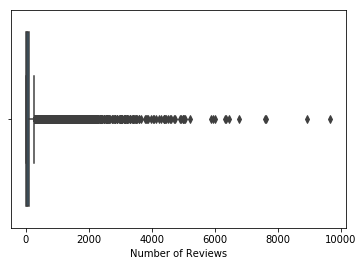

In [23]:
# построим boxplot для признака 'Number of Reviews'
sns.boxplot(df['Number of Reviews'])

In [24]:
# заполняем пропуски 0
df['Number of Reviews'].fillna(0, inplace=True)

Reviews

In [25]:
# в признаке 'Reviews' пропуска. Заменим их на пустую строку, которая встречается в признаке
df['Reviews'] = df['Reviews'].fillna('[[], []]')

In [26]:
# сохраним информацию о пустых строках в отдельный признак 
df['Reviews_Nan'] = (df['Reviews']=='[[], []]').astype('float64')

In [27]:
# созданим признак 'date_of_Review', где будут храниться только даты отзывов
df['date_of_Review'] = df['Reviews'].str.findall('\d+/\d+/\d+')

In [28]:
# разделим даты на два отдельных признака 
df['date_1'] = df.date_of_Review.map(lambda x: str(x)[2:12])
df['date_2'] = df.date_of_Review.map(lambda x: str(x)[-12:-2])
df['date_1']= pd.to_datetime(df['date_1'])
df['date_2']= pd.to_datetime(df['date_2'])

# и создадим признак с разницей этих дат 
df['delta_date'] = df['date_1'] - df['date_2']

In [29]:
df['delta_date'].fillna(0, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  """Entry point for launching an IPython kernel.


In [30]:
# переведем признак 'delta_date' в int64
df['delta_date'] = df['delta_date'].dt.days.astype('int64')

In [31]:
# и умножим значения меньше нуля на (-1)
df['delta_date'] = df['delta_date'].apply(lambda x: x if x > 0 else x*(-1))

City

In [32]:
# применим к столбцу 'City' функцию get_dummies
df = pd.get_dummies(df, columns=[ 'City',], dummy_na=True)

In [33]:
df.columns

Index(['Restaurant_id', 'Cuisine Style', 'Ranking', 'Number of Reviews',
       'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating', 'NaN_Price Range',
       'Price Range_$', 'Price Range_$$ - $$$', 'Price Range_$$$$',
       'Price Range_nan', 'Number_of_Reviews_isNAN', 'Reviews_Nan',
       'date_of_Review', 'date_1', 'date_2', 'delta_date', 'City_Amsterdam',
       'City_Athens', 'City_Barcelona', 'City_Berlin', 'City_Bratislava',
       'City_Brussels', 'City_Budapest', 'City_Copenhagen', 'City_Dublin',
       'City_Edinburgh', 'City_Geneva', 'City_Hamburg', 'City_Helsinki',
       'City_Krakow', 'City_Lisbon', 'City_Ljubljana', 'City_London',
       'City_Luxembourg', 'City_Lyon', 'City_Madrid', 'City_Milan',
       'City_Munich', 'City_Oporto', 'City_Oslo', 'City_Paris', 'City_Prague',
       'City_Rome', 'City_Stockholm', 'City_Vienna', 'City_Warsaw',
       'City_Zurich', 'City_nan'],
      dtype='object')

Ranking

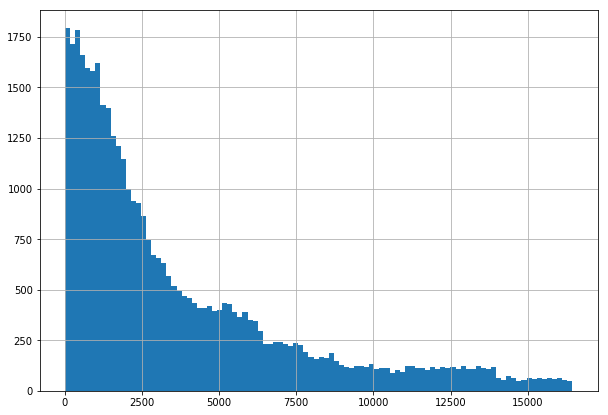

In [34]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

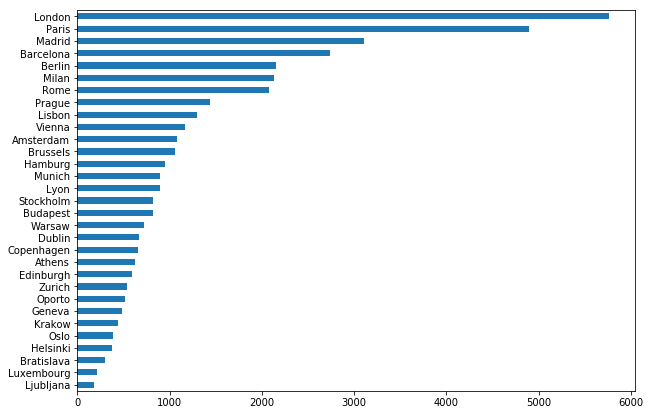

In [35]:
# У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?
df_train['City'].value_counts(ascending=True).plot(kind='barh')

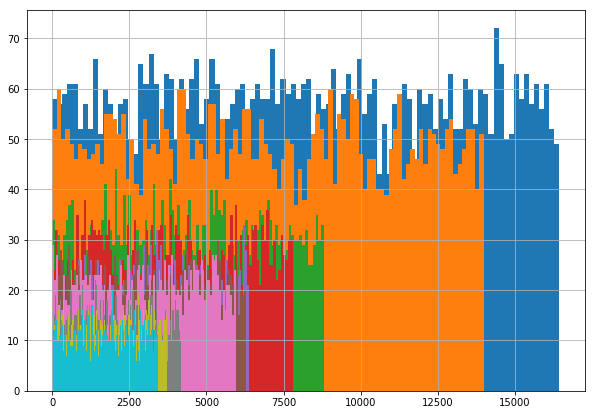

In [36]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.


### Посмотрим распределение целевой переменной

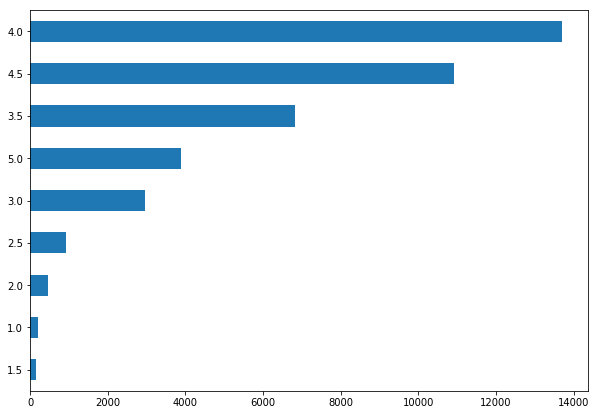

In [37]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

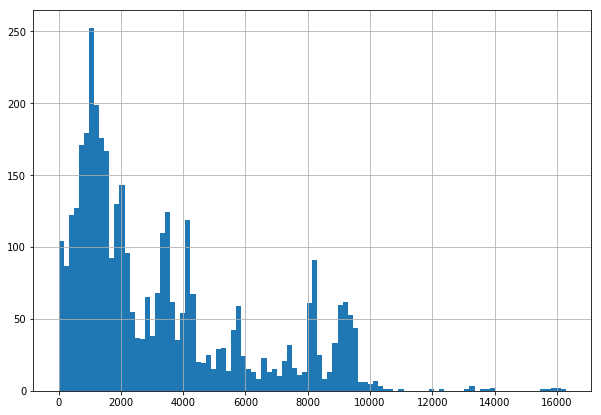

In [38]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

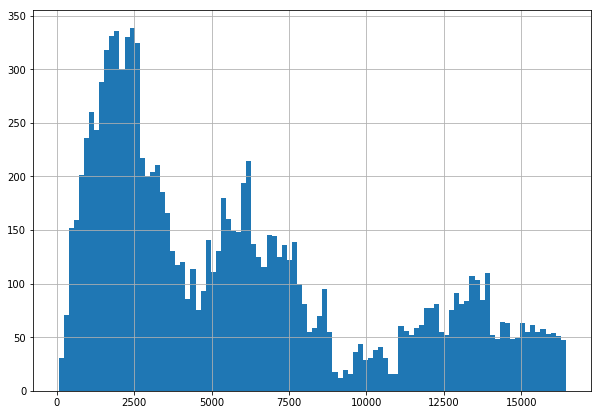

In [39]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

ID_TA

In [40]:
df['ID_TA'] = df['ID_TA'].apply(lambda x: float(x[1:]))

URL_TA

In [41]:
df['URL_TA'] = df['URL_TA'].str.split('-').apply(lambda x: x[1][1:]).astype('float64')

In [42]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating', 'Reviews', 'date_of_Review', 'date_1', 'date_2'], axis=1)

In [43]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [44]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 51), (40000, 51), (40000, 46), (32000, 46), (8000, 46))

Model 

In [45]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [46]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [47]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [48]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.212966875


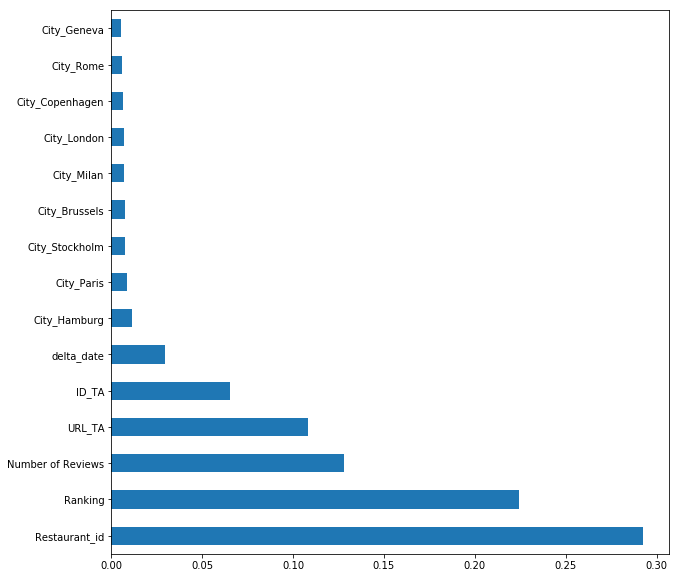

In [49]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [50]:
test_data.sample(10)

,Restaurant_id,Cuisine Style,Ranking,Number of Reviews,Reviews,URL_TA,ID_TA,Rating,NaN_Price Range,Price Range_$,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
3638,3638,1,2757.0,17.0,"[[], []]",187514.0,12506736.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
9060,9060,1,6161.0,46.0,"[['Family Dinner', 'Lovely back street pub'], ...",186338.0,4097949.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
9769,9769,1,744.0,0.0,"[[], []]",274772.0,12695167.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
7185,7185,1,1249.0,3.0,"[['Office catering', 'Early breakfast'], ['10/...",186605.0,10106032.0,0.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
7379,7379,1,195.0,47.0,"[['top', 'Second visit'], ['12/05/2017', '09/1...",187309.0,10735617.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
6952,6952,1,1601.0,0.0,"[[], []]",188113.0,11796028.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
5679,5679,1,1446.0,26.0,"[['Such a mixed feelings', 'Great breakfast!!'...",274856.0,9768707.0,0.0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
5036,5036,1,7982.0,38.0,"[['good food, well cooked, service OK', 'Good ...",186338.0,4236251.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2927,2927,1,845.0,46.0,"[['Good food, good service, also for large gr....",188644.0,1065761.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1360,1360,1,2754.0,67.0,"[['Lovely and unique', 'Tiny Place with Excell...",187147.0,4020824.0,0.0,0.0,0,...,0,0,1,0,0,0,0,0,0,0


In [51]:
test_data = test_data.drop(['Rating', 'Reviews', 'date_of_Review', 'date_1', 'date_2'], axis=1)

In [52]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [53]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [54]:
predict_submission

array([4.045, 4.38 , 4.56 , ..., 2.79 , 3.55 , 3.865])

In [55]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,4.045
1,id_1,4.380
2,id_2,4.560
3,id_3,4.330
4,id_4,4.400
5,id_5,4.520
6,id_6,4.275
7,id_7,3.860
8,id_8,4.500
9,id_9,4.575
